# Whisper's transcription plus Pyannote's Diarization 

Andrej Karpathy [suggested](https://twitter.com/karpathy/status/1574476200801538048?s=20&t=s5IMMXOYjBI6-91dib6w8g) training a classifier on top of  OpenAI [Whisper](https://openai.com/blog/whisper/) model features to identify the speaker, so we can visualize the speaker in the transcript. But, as [pointed out](https://twitter.com/tarantulae/status/1574493613362388992?s=20&t=s5IMMXOYjBI6-91dib6w8g) by Christian Perone, it seems that features from whisper wouldn't be that great for speaker recognition as its main objective is basically to ignore speaker differences.

In the following, I use [**`pyannote-audio`**](https://github.com/pyannote/pyannote-audio), a speaker diarization toolkit by Hervé Bredin, to identify the speakers, and then match it with the transcriptions of Whispr. I do it on the first 30 minutes of  Lex's 2nd [interview](https://youtu.be/SGzMElJ11Cc) with Yann LeCun. Check the result [**here**](https://majdoddin.github.io/lexicap.html). 

To make it easier to match the transcriptions to diarizations by speaker change, Sarah Kaiser [suggested](https://github.com/openai/whisper/discussions/264#discussioncomment-3825375) runnnig the pyannote.audio first and  then just running whisper on the split-by-speaker chunks. 
For sake of performance (and transcription quality?), we attach the audio segements into a single audio file with a silent spacer as a seperator, and run whisper on it. Enjoy it!

## Setup

In [1]:
#@markdown # **Install libraries** 🏗️
#@markdown This cell will take a little while to download several libraries.
#@markdown Whisper will be downloaded later

#@markdown ---

! pip install git+https://github.com/openai/whisper.git
! pip install pytube

import sys
import warnings
from pathlib import Path
import pytube
import subprocess
import torch
import shutil
import numpy as np
from IPython.display import display, Markdown, YouTubeVideo

device = torch.device('cuda:0')
print('Using device:', device, file=sys.stderr)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-rnhv4oa8
  Running command git clone -q https://github.com/openai/whisper.git /tmp/pip-req-build-rnhv4oa8
     |████████████████████████████████| 5.8 MB 4.5 MB/s 
     |████████████████████████████████| 7.6 MB 17.4 MB/s 
     |████████████████████████████████| 182 kB 26.5 MB/s 
  Created wheel for whisper: filename=whisper-1.0-py3-none-any.whl size=1175324 sha256=b40fd25e3c3083dce109dc415d90b6ad500171510da9c9b21d7371ed8d1ff648
  Stored in directory: /tmp/pip-ephem-wheel-cache-mt97a_rj/wheels/a7/70/18/b7693c07b1d18b3dafb328f5d0496aa0d41a9c09ef332fd8e6
Successfully built whisper
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 56 kB 2.6 MB/s 


Using device: cuda:0


In [2]:
#@markdown # **Check GPU type** 🕵️

#@markdown The type of GPU you get assigned in your Colab session defined the speed at which the video will be transcribed.
#@markdown The higher the number of floating point operations per second (FLOPS), the faster the transcription.
#@markdown But even the least powerful GPU available in Colab is able to run any Whisper model.
#@markdown Make sure you've selected `GPU` as hardware accelerator for the Notebook (Runtime &rarr; Change runtime type &rarr; Hardware accelerator).

#@markdown |  GPU   |  GPU RAM   | FP32 teraFLOPS |     Availability   |
#@markdown |:------:|:----------:|:--------------:|:------------------:|
#@markdown |  T4    |    16 GB   |       8.1      |         Free       |
#@markdown | P100   |    16 GB   |      10.6      |      Colab Pro     |
#@markdown | V100   |    16 GB   |      15.7      |  Colab Pro (Rare)  |

#@markdown ---
#@markdown **Factory reset your Notebook's runtime if you want to get assigned a new GPU.**

!nvidia-smi -L

!nvidia-smi

GPU 0: Tesla T4 (UUID: GPU-b4c8f798-0a85-ae68-0499-6ec12a325948)
Fri Dec 16 02:09:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                       

In [3]:
#@markdown # **Optional:** Save data in Google Drive 💾
#@markdown Enter a Google Drive path and run this cell if you want to store the results inside Google Drive.

# Uncomment to copy generated images to drive, faster than downloading directly from colab in my experience.
from google.colab import drive
drive_mount_path = Path("/") / "content" / "drive"
drive.mount(str(drive_mount_path))
drive_mount_path /= "My Drive"
#@markdown ---
drive_path = "Colab Notebooks/Whisper Youtube" #@param {type:"string"}
#@markdown ---
#@markdown **Run this cell again if you change your Google Drive path.**

drive_whisper_path = drive_mount_path / Path(drive_path.lstrip("/"))
drive_whisper_path.mkdir(parents=True, exist_ok=True)

Mounted at /content/drive


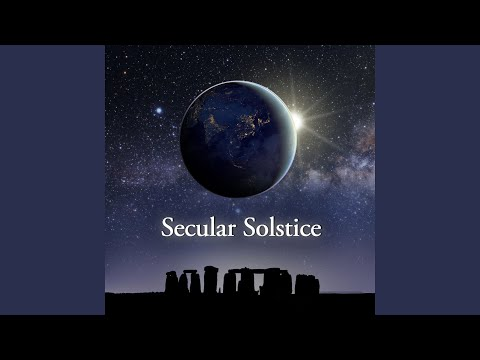

In [4]:
#@markdown # **Video selection** 📺

#@markdown Enter the URL of the Youtube video you want to transcribe, wether you want to save the audio file in your Google Drive, and run the cell.

Type = "Youtube video or playlist" #@param ['Youtube video or playlist', 'Google Drive']
#@markdown ---
#@markdown #### **Youtube video or playlist**
URL = "https://www.youtube.com/watch?v=iaFNlohn3z8" #@param {type:"string"}
store_audio = True #@param {type:"boolean"}
#@markdown ---
#@markdown #### **Google Drive video, audio (mp4, wav), or folder containing video and/or audio files**
video_path = "Colab Notebooks/Whisper Youtube/test folder/" #@param {type:"string"}
#@markdown ---
#@markdown **Run this cell again if you change the video.**

video_path_local_list = []

if Type == "Youtube video or playlist":
    
    try:
        list_video_yt = [pytube.YouTube(URL)]
    except Exception:
        try:
            list_video_yt = list(pytube.Playlist(URL).videos)
        except Exception:
            raise(RuntimeError(f"{URL} isn't recgnized."))
    
    for video_yt in list_video_yt:
        try:
            video_yt.check_availability()
            display(
                YouTubeVideo(video_yt.video_id)
            )
        except pytube.exceptions.VideoUnavailable:
            display(
                Markdown(f"**{URL} isn't available.**"),
            )
            raise(RuntimeError(f"{URL} isn't available."))
        video_path_local = Path(".").resolve() / (video_yt.video_id+".mp4")
        video_yt.streams.filter(
            type="audio",
            mime_type="audio/mp4",
            abr="48kbps"
        ).first().download(
            output_path = video_path_local.parent,
            filename = video_path_local.name
        )
        if store_audio:
            shutil.copy(video_path_local, drive_whisper_path / video_path_local.name)
        video_path_local_list.append(video_path_local)

elif Type == "Google Drive":
    # video_path_drive = drive_mount_path / Path(video_path.lstrip("/"))
    for video_path_drive in (drive_mount_path / Path(video_path.lstrip("/"))).glob("**/*"):
        video_path_local = Path(".").resolve() / (video_path_drive.name)
        shutil.copy(video_path_drive, video_path_local)
        if video_path_drive.is_file():
            display(Markdown(f"**{str(video_path_drive)} selected for transcription.**"))
        else:
            display(Markdown(f"**{str(video_path_drive)} does not exists.**"))
            raise(RuntimeError(f"{str(video_path_drive)} does not exists."))
        video_path_local_list.append(video_path_local)
else:
    raise(TypeError("Please select supported input type."))

for video_path_local in video_path_local_list:
    if video_path_local.suffix == ".mp4":
        video_path_local = video_path_local.with_suffix(".wav")
        result  = subprocess.run(["ffmpeg", "-i", str(video_path_local.with_suffix(".mp4")), "-vn", "-acodec", "pcm_s16le", "-ar", "16000", "-ac", "1", str(video_path_local)])


In [9]:
video_path_local_list[0]

PosixPath('/content/iaFNlohn3z8.mp4')

## Preparing the audio file

 Installing `yt-dlp` and downloading the [video](https://).

In [7]:
!pip install -U yt-dlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.8 MB 4.7 MB/s 
     |████████████████████████████████| 357 kB 75.4 MB/s 
     |████████████████████████████████| 106 kB 70.5 MB/s 
     |████████████████████████████████| 193 kB 81.8 MB/s 
     |████████████████████████████████| 2.3 MB 62.0 MB/s 


In [8]:
!wget -O - -q  https://github.com/yt-dlp/FFmpeg-Builds/releases/download/latest/ffmpeg-master-latest-linux64-gpl.tar.xz | xz -qdc| tar -x

In [ ]:
!yt-dlp -xv --ffmpeg-location ffmpeg-master-latest-linux64-gpl/bin --audio-format wav  -o lecun.wav -- https://youtu.be/SGzMElJ11Cc

[debug] Command-line config: ['-xv', '--ffmpeg-location', 'ffmpeg-master-latest-linux64-gpl/bin', '--audio-format', 'wav', '-o', 'lecun.wav', '--', 'https://youtu.be/SGzMElJ11Cc']
[debug] Encodings: locale UTF-8, fs utf-8, pref UTF-8, out UTF-8, error UTF-8, screen UTF-8
[debug] yt-dlp version 2022.10.04 [4e0511f] (pip) API
[debug] Python 3.7.14 (CPython 64bit) - Linux-5.10.133+-x86_64-with-Ubuntu-18.04-bionic (glibc 2.26)
[debug] Checking exe version: ffmpeg-master-latest-linux64-gpl/bin/ffmpeg -bsfs
[debug] Checking exe version: ffmpeg-master-latest-linux64-gpl/bin/ffprobe -bsfs
[debug] exe versions: ffmpeg N-108603-ge10e27a2ea-20221010 (setts), ffprobe N-108603-ge10e27a2ea-20221010
[debug] Optional libraries: Cryptodome-3.15.0, brotli-1.0.9, certifi-2022.09.24, mutagen-1.46.0, sqlite3-2.6.0, websockets-10.3
[debug] Proxy map: {}
[debug] Loaded 1690 extractors
[debug] [youtube] Extracting URL: https://youtu.be/SGzMElJ11Cc
[youtube] SGzMElJ11Cc: Downloading webpage
[youtube] SGzMElJ11



> Indented block


Cutting the first 20 minutes of the video for further process.


In [ ]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pydub import AudioSegment

t1 = 0 * 1000 #Works in milliseconds
t2 = 20 * 60 * 1000

newAudio = AudioSegment.from_wav("lecun.wav")
a = newAudio[t1:t2]
a.export("lecun1.wav", format="wav") 


<_io.BufferedRandom name='lecun1.wav'>

`pyannote.audio` seems to miss the first 0.5 seconds of the audio, and, therefore, we prepend a spcacer.

> Indented block\



In [ ]:
audio = AudioSegment.from_wav("lecun1.wav")
spacermilli = 2000
spacer = AudioSegment.silent(duration=spacermilli)
audio = spacer.append(audio, crossfade=0)

audio.export('audio.wav', format='wav')

<_io.BufferedRandom name='audio.wav'>

## Pyannote's Diarization

[`pyannote.audio`](https://github.com/pyannote/pyannote-audio) is an open-source toolkit written in Python for **speaker diarization**. 

Based on [`PyTorch`](https://pytorch.org) machine learning framework, it provides a set of trainable end-to-end neural building blocks that can be combined and jointly optimized to build speaker diarization pipelines. 

`pyannote.audio` also comes with pretrained [models](https://huggingface.co/models?other=pyannote-audio-model) and [pipelines](https://huggingface.co/models?other=pyannote-audio-pipeline) covering a wide range of domains for voice activity detection, speaker segmentation, overlapped speech detection, speaker embedding reaching state-of-the-art performance for most of them. 

Installing Pyannote and running it on the video to generate the diarizations.

In [ ]:
!pip install   pyannote.audio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 385 kB 8.1 MB/s 
     |████████████████████████████████| 41 kB 470 kB/s 
     |████████████████████████████████| 47 kB 5.4 MB/s 
     |████████████████████████████████| 79 kB 7.5 MB/s 
     |████████████████████████████████| 51 kB 197 kB/s 
     |████████████████████████████████| 529 kB 67.1 MB/s 
     |████████████████████████████████| 101 kB 13.0 MB/s 
     |████████████████████████████████| 60 kB 9.0 MB/s 
     |████████████████████████████████| 585 kB 66.1 MB/s 
     |████████████████████████████████| 111 kB 74.4 MB/s 
     |████████████████████████████████| 498 kB 68.7 MB/s 
     |████████████████████████████████| 217 kB 75.5 MB/s 
     |████████████████████████████████| 117 kB 76.9 MB/s 
     |████████████████████████████████| 130 kB 73.0 MB/s 
     |████████████████████████████████| 348 kB 46.3 MB/s 
     |████████████████████████████████| 20

In [ ]:
from pyannote.audio import Pipeline

pipeline = Pipeline.from_pretrained('pyannote/speaker-diarization')

Downloading:   0%|          | 0.00/598 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/318 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/83.3M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.53M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/129k [00:00<?, ?B/s]

In [ ]:
DEMO_FILE = {'uri': 'blabal', 'audio': 'audio.wav'}
dz = pipeline(DEMO_FILE)  

with open("diarization.txt", "w") as text_file:
    text_file.write(str(dz))

In [ ]:
print(*list(dz.itertracks(yield_label = True))[:10], sep="\n")

(<Segment(2.03344, 36.8128)>, 0, 'SPEAKER_00')
(<Segment(38.1122, 51.3759)>, 0, 'SPEAKER_00')
(<Segment(51.8653, 90.2053)>, 1, 'SPEAKER_01')
(<Segment(91.2853, 92.9391)>, 1, 'SPEAKER_01')
(<Segment(94.8628, 116.497)>, 0, 'SPEAKER_00')
(<Segment(116.497, 124.124)>, 1, 'SPEAKER_01')
(<Segment(124.192, 151.597)>, 1, 'SPEAKER_01')
(<Segment(152.018, 179.12)>, 1, 'SPEAKER_01')
(<Segment(180.318, 194.037)>, 1, 'SPEAKER_01')
(<Segment(195.016, 207.385)>, 0, 'SPEAKER_00')


In [ ]:
def millisec(timeStr):
  spl = timeStr.split(":")
  s = (int)((int(spl[0]) * 60 * 60 + int(spl[1]) * 60 + float(spl[2]) )* 1000)
  return s

In [ ]:
import re
dz = open('diarization.txt').read().splitlines()
dzList = []
for l in dz:
  start, end =  tuple(re.findall('[0-9]+:[0-9]+:[0-9]+\.[0-9]+', string=l))
  start = millisec(start) - spacermilli
  end = millisec(end)  - spacermilli
  lex = not re.findall('SPEAKER_01', string=l)
  dzList.append([start, end, lex])

print(*dzList[:10], sep='\n')

[33, 34812, True]
[36112, 49375, True]
[49865, 88205, False]
[89285, 90939, False]
[92862, 114496, True]
[114496, 122124, False]
[122191, 149596, False]
[150018, 177119, False]
[178317, 192037, False]
[193015, 205385, True]


## Preparing audio file from the diarization

Attaching audio segements according to the diarization, with a spacer as the delimiter.

In [ ]:
from pydub import AudioSegment
import re 

sounds = spacer
segments = []

dz = open('diarization.txt').read().splitlines()
for l in dz:
  start, end =  tuple(re.findall('[0-9]+:[0-9]+:[0-9]+\.[0-9]+', string=l))
  start = int(millisec(start)) #milliseconds
  end = int(millisec(end))  #milliseconds
  
  segments.append(len(sounds))
  sounds = sounds.append(audio[start:end], crossfade=0)
  sounds = sounds.append(spacer, crossfade=0)

sounds.export("dz.wav", format="wav") #Exports to a wav file in the current path.

<_io.BufferedRandom name='dz.wav'>

In [ ]:
segments[:8]

[2000, 38779, 54042, 94382, 98036, 121670, 131297, 160702]

Freeing up some memory

In [ ]:
del   sounds, DEMO_FILE, pipeline, spacer,  audio, dz, a, newAudio

# **Youtube Videos Transcription with OpenAI's Whisper**

[![blog post shield](https://img.shields.io/static/v1?label=&message=Blog%20post&color=blue&style=for-the-badge&logo=openai&link=https://openai.com/blog/whisper)](https://openai.com/blog/whisper)
[![notebook shield](https://img.shields.io/static/v1?label=&message=Notebook&color=blue&style=for-the-badge&logo=googlecolab&link=https://colab.research.google.com/github/ArthurFDLR/whisper-youtube/blob/main/whisper_youtube.ipynb)](https://colab.research.google.com/github/ArthurFDLR/whisper-youtube/blob/main/whisper_youtube.ipynb)
[![repository shield](https://img.shields.io/static/v1?label=&message=Repository&color=blue&style=for-the-badge&logo=github&link=https://github.com/openai/whisper)](https://github.com/openai/whisper)
[![paper shield](https://img.shields.io/static/v1?label=&message=Paper&color=blue&style=for-the-badge&link=https://cdn.openai.com/papers/whisper.pdf)](https://cdn.openai.com/papers/whisper.pdf)
[![model card shield](https://img.shields.io/static/v1?label=&message=Model%20card&color=blue&style=for-the-badge&link=https://github.com/openai/whisper/blob/main/model-card.md)](https://github.com/openai/whisper/blob/main/model-card.md)

Whisper is a general-purpose speech recognition model. It is trained on a large dataset of diverse audio and is also a multi-task model that can perform multilingual speech recognition as well as speech translation and language identification.

This Notebook will guide you through the transcription of a Youtube video using Whisper. You'll be able to explore most inference parameters or use the Notebook as-is to store the transcript and video audio in your Google Drive.

In [ ]:
#@markdown # **Install Whisper** 🏗️
#@markdown **Important:** There is a version conflict with pyannote.audio resulting in an error (see this RP). Our workaround is to first run Pyannote and then whisper. You can safely ignore the error.

#@markdown ---

! pip install git+https://github.com/openai/whisper.git
import whisper

In [ ]:
#@markdown # **Model selection** 🧠

#@markdown As of the first public release, there are 4 pre-trained options to play with:

#@markdown |  Size  | Parameters | English-only model | Multilingual model | Required VRAM | Relative speed |
#@markdown |:------:|:----------:|:------------------:|:------------------:|:-------------:|:--------------:|
#@markdown |  tiny  |    39 M    |     `tiny.en`      |       `tiny`       |     ~1 GB     |      ~32x      |
#@markdown |  base  |    74 M    |     `base.en`      |       `base`       |     ~1 GB     |      ~16x      |
#@markdown | small  |   244 M    |     `small.en`     |      `small`       |     ~2 GB     |      ~6x       |
#@markdown | medium |   769 M    |    `medium.en`     |      `medium`      |     ~5 GB     |      ~2x       |
#@markdown | large  |   1550 M   |        N/A         |      `large`       |    ~10 GB     |       1x       |

#@markdown ---
Model = 'large' #@param ['tiny.en', 'tiny', 'base.en', 'base', 'small.en', 'small', 'medium.en', 'medium', 'large']
#@markdown ---
#@markdown **Run this cell again if you change the model.**

whisper_model = whisper.load_model(Model)

if Model in whisper.available_models():
    display(Markdown(
        f"**{Model} model is selected.**"
    ))
else:
    display(Markdown(
        f"**{Model} model is no longer available.**<br /> Please select one of the following:<br /> - {'<br /> - '.join(whisper.available_models())}"
    ))

100%|█████████████████████████████████████| 2.87G/2.87G [00:58<00:00, 52.4MiB/s]


**large model is selected.**

In [ ]:
#@markdown # **Run the model** 🚀

#@markdown Run this cell to execute the transcription of the video. This can take a while and very based on the length of the video and the number of parameters of the model selected above.

#@markdown ## **Parameters** ⚙️

#@markdown ### **Behavior control**
#@markdown ---
language = "English" #@param ['Auto detection', 'Afrikaans', 'Albanian', 'Amharic', 'Arabic', 'Armenian', 'Assamese', 'Azerbaijani', 'Bashkir', 'Basque', 'Belarusian', 'Bengali', 'Bosnian', 'Breton', 'Bulgarian', 'Burmese', 'Castilian', 'Catalan', 'Chinese', 'Croatian', 'Czech', 'Danish', 'Dutch', 'English', 'Estonian', 'Faroese', 'Finnish', 'Flemish', 'French', 'Galician', 'Georgian', 'German', 'Greek', 'Gujarati', 'Haitian', 'Haitian Creole', 'Hausa', 'Hawaiian', 'Hebrew', 'Hindi', 'Hungarian', 'Icelandic', 'Indonesian', 'Italian', 'Japanese', 'Javanese', 'Kannada', 'Kazakh', 'Khmer', 'Korean', 'Lao', 'Latin', 'Latvian', 'Letzeburgesch', 'Lingala', 'Lithuanian', 'Luxembourgish', 'Macedonian', 'Malagasy', 'Malay', 'Malayalam', 'Maltese', 'Maori', 'Marathi', 'Moldavian', 'Moldovan', 'Mongolian', 'Myanmar', 'Nepali', 'Norwegian', 'Nynorsk', 'Occitan', 'Panjabi', 'Pashto', 'Persian', 'Polish', 'Portuguese', 'Punjabi', 'Pushto', 'Romanian', 'Russian', 'Sanskrit', 'Serbian', 'Shona', 'Sindhi', 'Sinhala', 'Sinhalese', 'Slovak', 'Slovenian', 'Somali', 'Spanish', 'Sundanese', 'Swahili', 'Swedish', 'Tagalog', 'Tajik', 'Tamil', 'Tatar', 'Telugu', 'Thai', 'Tibetan', 'Turkish', 'Turkmen', 'Ukrainian', 'Urdu', 'Uzbek', 'Valencian', 'Vietnamese', 'Welsh', 'Yiddish', 'Yoruba']
#@markdown > Language spoken in the audio, use `Auto detection` to let Whisper detect the language.
#@markdown ---
verbose = 'Live transcription' #@param ['Live transcription', 'Progress bar', 'None']
#@markdown > Whether to print out the progress and debug messages.
#@markdown ---
output_type = 'All' #@param ['All', '.txt', '.vtt', '.srt']
#@markdown > Type of file to generate to record the transcription.
#@markdown ---
task = 'transcribe' #@param ['transcribe', 'translate']
#@markdown > Whether to perform X->X speech recognition (`transcribe`) or X->English translation (`translate`).
#@markdown ---

#@markdown <br/>

#@markdown ### **Optional: Fine tunning** 
#@markdown ---
temperature = 0.15 #@param {type:"slider", min:0, max:1, step:0.05}
#@markdown > Temperature to use for sampling.
#@markdown ---
temperature_increment_on_fallback = 0.2 #@param {type:"slider", min:0, max:1, step:0.05}
#@markdown > Temperature to increase when falling back when the decoding fails to meet either of the thresholds below.
#@markdown ---
best_of = 5 #@param {type:"integer"}
#@markdown > Number of candidates when sampling with non-zero temperature.
#@markdown ---
beam_size = 5 #@param {type:"integer"}
#@markdown > Number of beams in beam search, only applicable when temperature is zero.
#@markdown ---
patience = 1.0 #@param {type:"number"}
#@markdown > Optional patience value to use in beam decoding, as in [*Beam Decoding with Controlled Patience*](https://arxiv.org/abs/2204.05424), the default (1.0) is equivalent to conventional beam search.
#@markdown ---
length_penalty = -0.05 #@param {type:"slider", min:-0.05, max:1, step:0.05}
#@markdown > Optional token length penalty coefficient (alpha) as in [*Google's Neural Machine Translation System*](https://arxiv.org/abs/1609.08144), set to negative value to uses simple length normalization.
#@markdown ---
suppress_tokens = "-1" #@param {type:"string"}
#@markdown > Comma-separated list of token ids to suppress during sampling; '-1' will suppress most special characters except common punctuations.
#@markdown ---
initial_prompt = "" #@param {type:"string"}
#@markdown > Optional text to provide as a prompt for the first window.
#@markdown ---
condition_on_previous_text = True #@param {type:"boolean"}
#@markdown > if True, provide the previous output of the model as a prompt for the next window; disabling may make the text inconsistent across windows, but the model becomes less prone to getting stuck in a failure loop.
#@markdown ---
fp16 = True #@param {type:"boolean"}
#@markdown > whether to perform inference in fp16.
#@markdown ---
compression_ratio_threshold = 2.4 #@param {type:"number"}
#@markdown > If the gzip compression ratio is higher than this value, treat the decoding as failed.
#@markdown ---
logprob_threshold = -1.0 #@param {type:"number"}
#@markdown > If the average log probability is lower than this value, treat the decoding as failed.
#@markdown ---
no_speech_threshold = 0.6 #@param {type:"slider", min:-0.0, max:1, step:0.05}
#@markdown > If the probability of the <|nospeech|> token is higher than this value AND the decoding has failed due to `logprob_threshold`, consider the segment as silence.
#@markdown ---

verbose_lut = {
    'Live transcription': True,
    'Progress bar': False,
    'None': None
}

args = dict(
    language = (None if language == "Auto detection" else language),
    verbose = verbose_lut[verbose],
    task = task,
    temperature = temperature,
    temperature_increment_on_fallback = temperature_increment_on_fallback,
    best_of = best_of,
    beam_size = beam_size,
    patience=patience,
    length_penalty=(length_penalty if length_penalty>=0.0 else None),
    suppress_tokens=suppress_tokens,
    initial_prompt=(None if not initial_prompt else initial_prompt),
    condition_on_previous_text=condition_on_previous_text,
    fp16=fp16,
    compression_ratio_threshold=compression_ratio_threshold,
    logprob_threshold=logprob_threshold,
    no_speech_threshold=no_speech_threshold
)

temperature = args.pop("temperature")
temperature_increment_on_fallback = args.pop("temperature_increment_on_fallback")
if temperature_increment_on_fallback is not None:
    temperature = tuple(np.arange(temperature, 1.0 + 1e-6, temperature_increment_on_fallback))
else:
    temperature = [temperature]

if Model.endswith(".en") and args["language"] not in {"en", "English"}:
    warnings.warn(f"{Model} is an English-only model but receipted '{args['language']}'; using English instead.")
    args["language"] = "en"

for video_path_local in video_path_local_list:
    display(Markdown(f"### {video_path_local}"))

    video_transcription = whisper.transcribe(
        whisper_model,
        str(video_path_local),
        temperature=temperature,
        **args,
    )

    # Save output
    writing_lut = {
        '.txt': whisper.utils.write_txt,
        '.vtt': whisper.utils.write_vtt,
        '.srt': whisper.utils.write_srt,
    }

    if output_type == "All":
        for suffix, write_suffix in writing_lut.items():
            transcript_local_path = video_path_local.with_suffix(suffix)
            with open(transcript_local_path, "w", encoding="utf-8") as f:
                write_suffix(video_transcription["segments"], file=f)
            try:
                transcript_drive_path = drive_whisper_path / transcript_local_path.name
                shutil.copy(transcript_local_path, transcript_drive_path)
                display(Markdown(f"**Transcript file created: {transcript_drive_path}**"))
            except:
                display(Markdown(f"**Transcript file created: {transcript_local_path}**"))
    else:
        transcript_local_path = video_path_local.with_suffix(output_type)

        with open(transcript_local_path, "w", encoding="utf-8") as f:
            writing_lut[output_type](video_transcription["segments"], file=f)
        try:
            transcript_drive_path = drive_whisper_path / transcript_local_path.name
            shutil.copy(transcript_local_path, transcript_drive_path)
            display(Markdown(f"**Transcript file created: {transcript_drive_path}**"))
        except:
            display(Markdown(f"**Transcript file created: {transcript_local_path}**"))

### /content/PEL_ep_305pt2_11-7-22.mp3

[00:00.000 --> 00:04.080]  This episode of The Partially Examined Life is sponsored by GiveWell.org.
[00:04.080 --> 00:09.040]  Get your first-time high-impact donation matched up to $100 before the end of the year.
[00:09.040 --> 00:14.080]  This episode is sponsored by BetterHelp. Give online therapy a try at BetterHelp.com
[00:14.080 --> 00:17.440]  slash partially and get on your way to being your best self.
[00:17.440 --> 00:31.040]  You're listening to The Partially Examined Life. This is part two of episode 305 on Blood Meridian.
[00:31.040 --> 00:37.600]  We were talking about the relative aptness of the term gratuitous to describe the violence
[00:37.600 --> 00:42.320]  in Blood Meridian and wanted to make sure that we got to talking about
[00:42.320 --> 00:45.520]  Judge Holden's characterizing of the meaning of life.
[00:45.520 --> 00:49.920]  Okay. Shall I set us up for a little bit of that?
[00:49.920 --> 00:54.960]  Before you do, let me just throw in that thing. So there

**Transcript file created: /content/drive/My Drive/Colab Notebooks/Whisper Youtube/PEL_ep_305pt2_11-7-22.txt**

**Transcript file created: /content/drive/My Drive/Colab Notebooks/Whisper Youtube/PEL_ep_305pt2_11-7-22.vtt**

**Transcript file created: /content/drive/My Drive/Colab Notebooks/Whisper Youtube/PEL_ep_305pt2_11-7-22.srt**

In [ ]:
!pip install -U webvtt-py

In [ ]:
import webvtt

captions = [[(int)(millisec(caption.start)), (int)(millisec(caption.end)),  caption.text] for caption in webvtt.read('dz.wav.vtt')]
print(*captions[:8], sep='\n')